# Computational Game Theory Group Assignment: Evolutionary Dynamics  of N-person Hawk-Dove games
Sam Vanspringel - 0580462 - VUB

Hendrik Temmerman - 0568045 - VUB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import egttools as egt
import nashpy as nash
import scipy

from scipy.special import comb

from egttools.plotting.helpers import (
    xy_to_barycentric_coordinates, calculate_stationary_points, calculate_stability
)
from egttools.helpers.vectorized import (
    vectorized_replicator_equation, vectorized_barycentric_to_xy_coordinates
)

from egttools.plotting import Simplex2D

from egttools.analytical import replicator_equation_n_player
from egttools.analytical.utils import (calculate_gradients, find_roots, check_replicator_stability_pairwise_games,)
from egttools.plotting import plot_gradients
from pprint import pprint

In [2]:
nb_strategies = 2

# 1. Infinite Populations

In [3]:
# define the parameters
R = 1.0
N = 5

#n_hawks = np.random.randint(0, N)
#n_doves = N - n_hawks

#x_hawks = n_hawks/N
#x_doves = 1-x_hawks

n_steps = 100

In [4]:
# Payoff hawks
def P_H(amount_hawks, c_h):
    P_H = 0
    total_hawks = amount_hawks + 1
    if total_hawks > 0:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

# Payoff doves
def P_D(amount_hawks):
    if amount_hawks == 0:
        P_D = R/N
    elif amount_hawks > 0:
        P_D = 0.0
    return P_D



In [5]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H(i, c_h)
    return average_fitness
    
# Fitness doves
def average_fitness_doves(N, x_fraction):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D(i+1)
    return average_fitness

# Fitness average
def average_fitness_population(x_hawks, x_doves, fitness_hawks, fitness_doves):
    return (x_hawks * fitness_hawks) + (x_doves * fitness_doves)
    


In [6]:
#Experiment (Figure: 1.A)

c_h_results = np.empty((3, n_steps))
dove_densities = np.linspace(0, 1, num=n_steps, dtype=np.float64)

for index, c_h in enumerate([0.1, 0.5, 0.9]):
    
    x_dot = np.empty(n_steps)

    for i in range(len(dove_densities)):
        x = dove_densities[i]
        fitness_doves = average_fitness_doves(N, x)
        fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

        x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)
        
    c_h_results[index] = x_dot


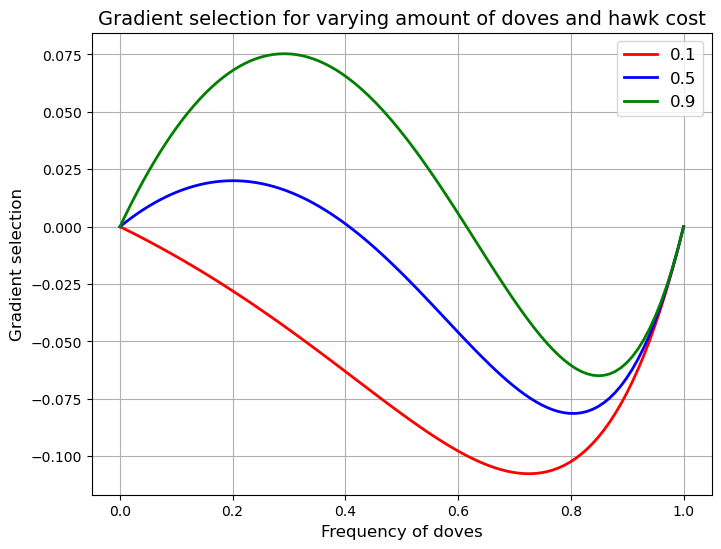

In [7]:
#Plotting
labels = ["0.1", "0.5", "0.9"]
colors = ["red", "blue", "green"]

# Plot each array
plt.figure(figsize=(8, 6))
for i, values in enumerate(c_h_results):
    plt.plot(dove_densities, values, label=labels[i], color=colors[i], linewidth=2)

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [8]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq


dove_densities = np.linspace(0, 1, num=n_steps, dtype=np.float64)
N_values = [5,10,20,50,100]
eq_results =  np.empty((len(N_values), n_steps))

for i_N, N in enumerate(N_values):
    eq = []
    for index, c_h in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        
        x_dot = np.empty(n_steps)

        for i in range(len(dove_densities)):
            x = dove_densities[i]
            fitness_doves = average_fitness_doves(N, x)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot)  
        
        if len(equilibria) > 2:
            eq.append(dove_densities[equilibria[1]])
        else: 
            eq.append(dove_densities[equilibria[0]])

    eq_results[i_N] = eq

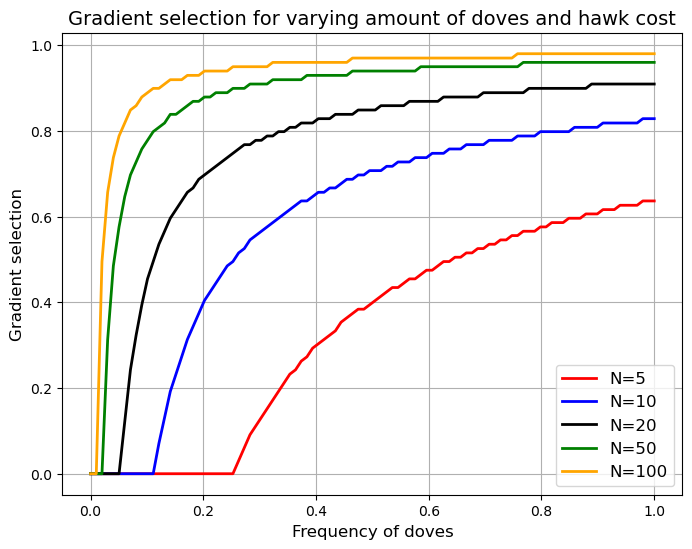

In [9]:

#Plotting
labels = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors = ["red", "blue", "black", "green", "orange"]

# Plot each array
plt.figure(figsize=(8, 6))
for i, values in enumerate(eq_results):
    plt.plot(dove_densities, values, label=labels[i], color=colors[i], linewidth=2)

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [9]:
# Parameters
R = 1  
N = 5
c_H_values = [0.1, 0.5]  
Z_values = [10, 20, 100]  
w = 1  

In [10]:
def gradient_of_selection(k, Z, c_H, N, w):

    fraction = k/Z
    f_d = average_fitness_doves(N, fraction)
    f_h = average_fitness_hawks(N, (1-fraction), c_H)

    T_plus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_d - f_h))))
    T_minus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_h - f_d))))

    gradient = T_plus - T_minus
    return gradient

def calculate_gradients_figure_2A(Z, c_H, N, w):
    
    k_values = np.arange(Z + 1)
    g_values = np.empty(len(k_values))
    
    for i, k in enumerate(k_values):
        g_values[i] = gradient_of_selection(k, Z, c_H, N, w)

    X_as = k_values / Z
    
    return X_as, g_values

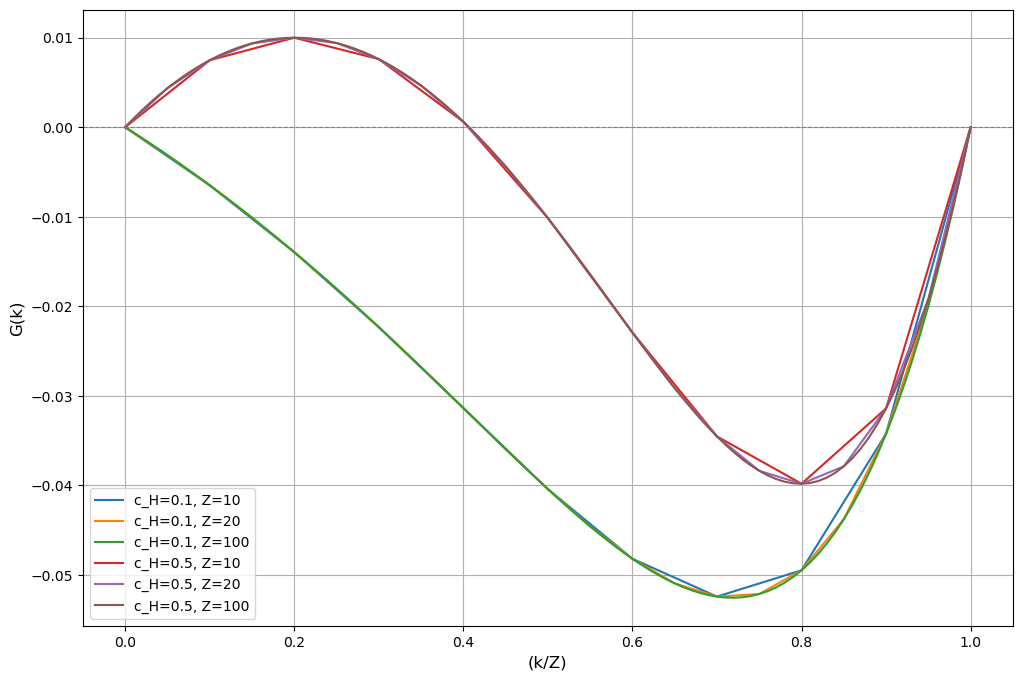

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

for c_H in c_H_values:
    for Z in Z_values:
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)
        ax.plot(X_as, g_values, label=f"c_H={c_H}, Z={Z}")

# Plot details
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_xlabel("(k/Z)", fontsize=12)
ax.set_ylabel("G(k)", fontsize=12)
ax.legend()
ax.grid()
plt.show()

In [12]:
Z = 100
R = 1
w = 1
dove_densities = np.linspace(0, 1, num=n_steps, dtype=np.float64)
n_steps = 100

In [ ]:
def calculate_gradients_figure_2B(Z, N, w):
    eq = []
    for index, c_H in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)
        
        equilibria = find_equilibria_indexes(g_values)  
        
        if len(equilibria) > 2:
            eq.append(dove_densities[equilibria[1]])
        else: 
            eq.append(dove_densities[equilibria[0]])

    return eq

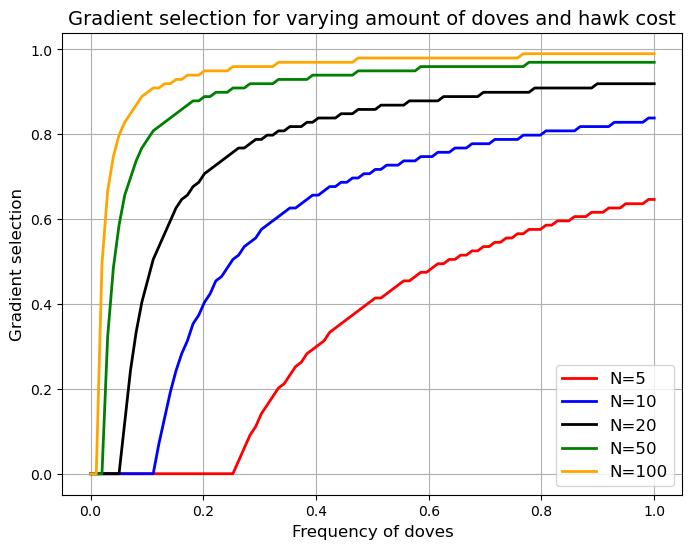

In [14]:
#Plotting
labels = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors = ["red", "blue", "black", "green", "orange"]
N_values = [5,10,20,50,100]


# Plot each array
plt.figure(figsize=(8, 6))
for i, N in enumerate(N_values):
    values = calculate_gradients_figure_2B(Z, N, w)
    plt.plot(dove_densities, values, label=labels[i], color=colors[i], linewidth=2)

  

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

# Figure 3

In [69]:
# Parameters
N = 5 
R = 1 
n_steps = 100

In [67]:
# Payoff hawks
def P_H(amount_hawks, c_h, T):
    P_H = 0
    total_hawks = amount_hawks + 1
    if total_hawks > N * T:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

# Payoff doves
def P_D(amount_doves, c_d, T):
    P_D = 0
    total_doves = amount_doves + 1
    if total_doves < N * T:
        P_D = (R - amount_doves*c_d) / total_doves
    return P_D

In [71]:
def P_H(amount_hawks, c_h, T):
    if amount_hawks < N * T:
        return 0
    return (R - amount_hawks * c_h) / (amount_hawks + 1)

def P_D(amount_doves, c_d, T):
    if amount_doves >= N * T:
        return (R - amount_doves * c_d) / (amount_doves + 1)
    return 0

In [63]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H(i, c_h, T)
    return average_fitness
    
# Fitness doves
def average_fitness_doves(N, x_fraction, c_d, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D(i+1, c_d, T)
    return average_fitness

In [64]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq

In [65]:
def figure3A(T, c_d):

    dove_densities = np.linspace(0, 1, num=n_steps, dtype=np.float64)

    eq = []
    for index, c_h in enumerate(dove_densities):
        
        x_dot = np.empty(n_steps)

        for i in range(len(dove_densities)):
            x = dove_densities[i]
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)
            x_dot[i] = x * (1 - x) * (fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot)  
        
        if len(equilibria) > 2:
            eq.append(dove_densities[equilibria[1]])
        else: 
            eq.append(dove_densities[equilibria[0]])

    return eq, dove_densities


def figure3B(T, c_h):

    dove_densities = np.linspace(0, 1, num=n_steps, dtype=np.float64)

    eq = []
    for index, c_d in enumerate(dove_densities):
        
        x_dot = np.empty(n_steps)

        for i in range(len(dove_densities)):
            x = dove_densities[i]
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)

            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot)  
        
        if len(equilibria) > 2:
            eq.append(dove_densities[equilibria[1]])
        else: 
            eq.append(dove_densities[equilibria[0]])

    return eq, dove_densities

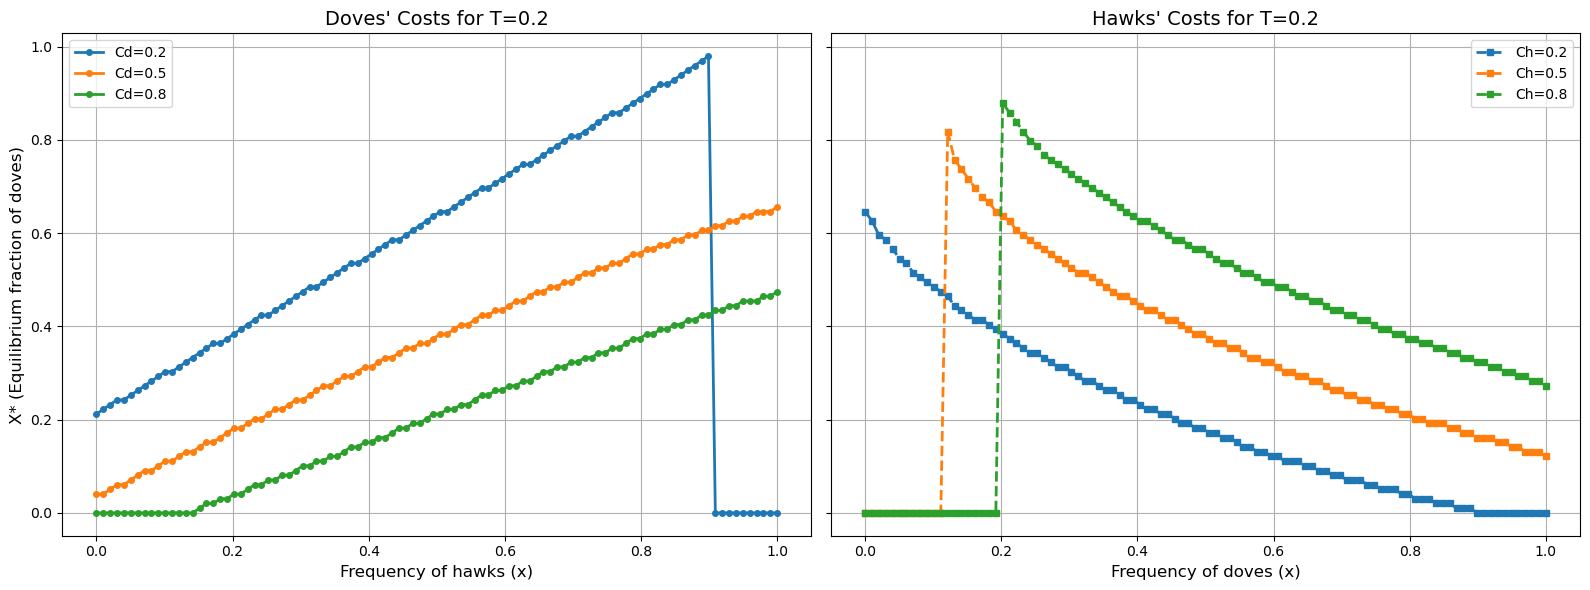

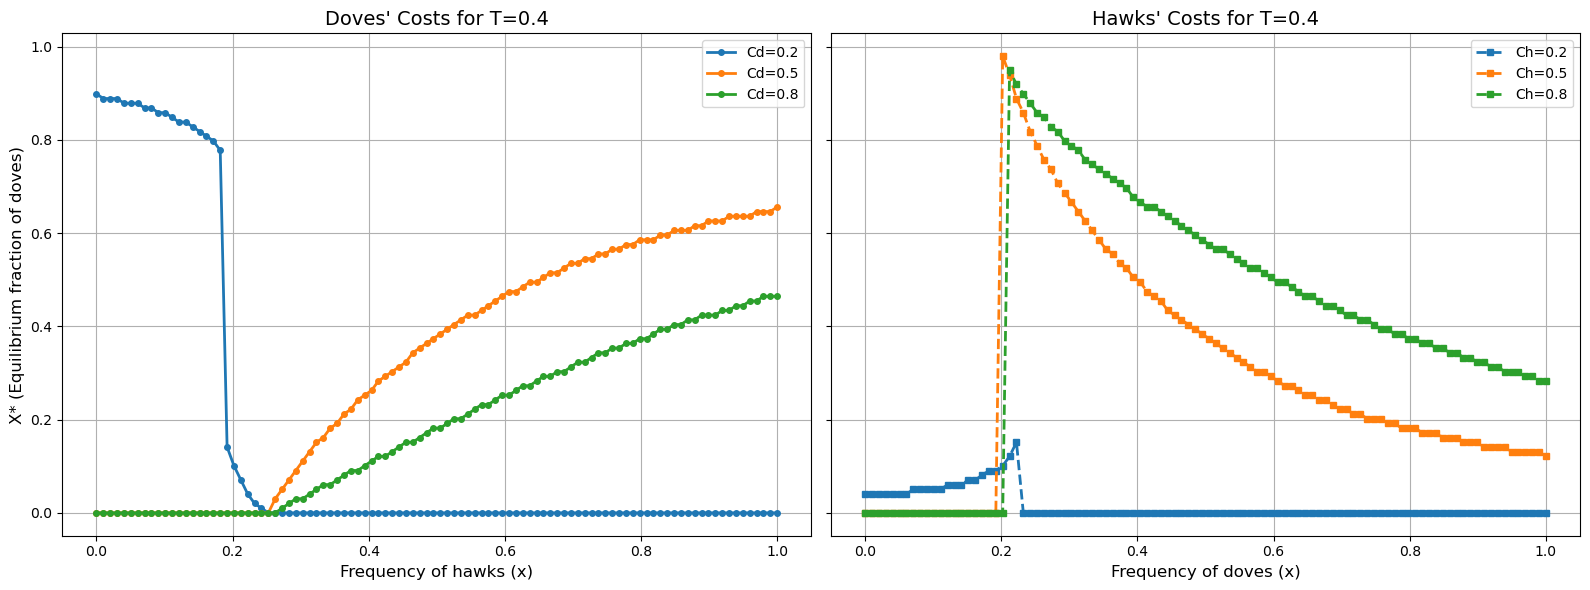

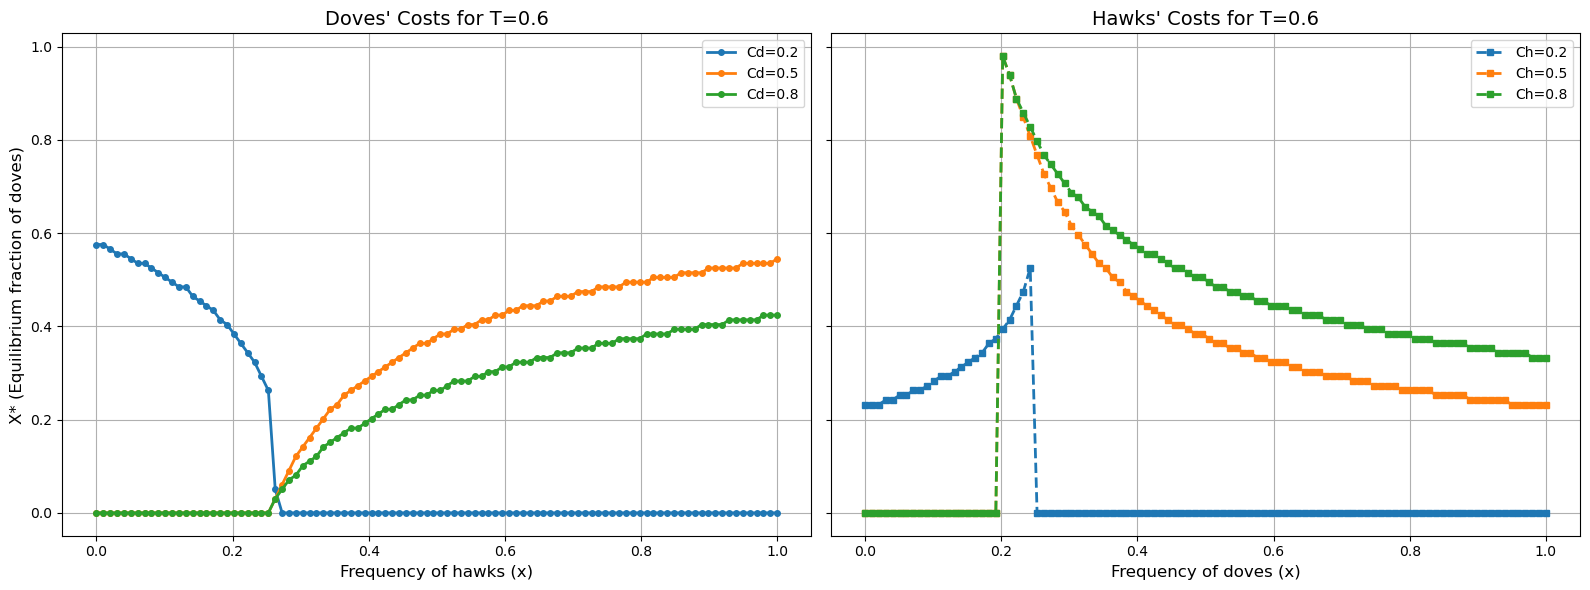

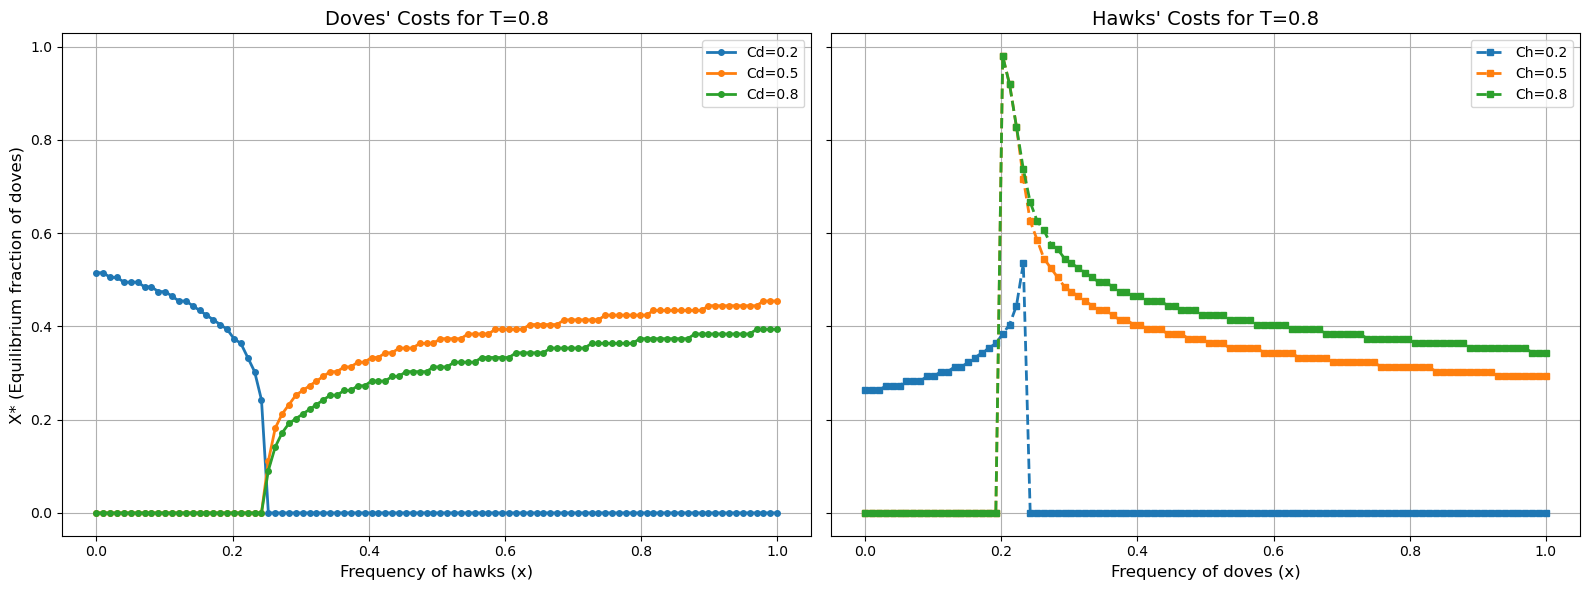

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and parameter values
T_labels = ["T=0.2", "T=0.4", "T=0.6", "T=0.8"]
T_values = [0.2, 0.4, 0.6, 0.8]

Doves_Costs_labels = ["Cd=0.2", "Cd=0.5", "Cd=0.8"]
Doves_Costs = [0.2, 0.5, 0.8]

Hawks_Costs_labels = ["Ch=0.2", "Ch=0.5", "Ch=0.8"]
Hawks_Costs = [0.2, 0.5, 0.8]

# Combined plot for Figure 3A (Doves' Costs) and 3B (Hawks' Costs)
def plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels):
    for t_idx, T in enumerate(T_values):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        # Panel for Doves' Costs
        for d_idx, c_d in enumerate(Doves_Costs):
            y_as, x_as = figure3A(T, c_d)  # Assuming figure3A is already corrected
            axes[0].plot(x_as, y_as, label=Doves_Costs_labels[d_idx],
                         linestyle='-', marker='o', markersize=4, linewidth=2)

        axes[0].set_title(f"Doves' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[0].set_xlabel("Frequency of hawks (x)", fontsize=12)
        axes[0].set_ylabel("X* (Equilibrium fraction of doves)", fontsize=12)
        axes[0].legend(fontsize=10, loc="best")
        axes[0].grid(True)

        # Panel for Hawks' Costs
        for h_idx, c_h in enumerate(Hawks_Costs):
            y_as, x_as = figure3B(T, c_h)  # Assuming figure3B is implemented correctly
            axes[1].plot(x_as, y_as, label=Hawks_Costs_labels[h_idx],
                         linestyle='--', marker='s', markersize=4, linewidth=2)

        axes[1].set_title(f"Hawks' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[1].set_xlabel("Frequency of doves (x)", fontsize=12)
        axes[1].legend(fontsize=10, loc="best")
        axes[1].grid(True)

        # Adjust layout and show
        plt.tight_layout()
        plt.show()

# Call the plotting function
plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels)


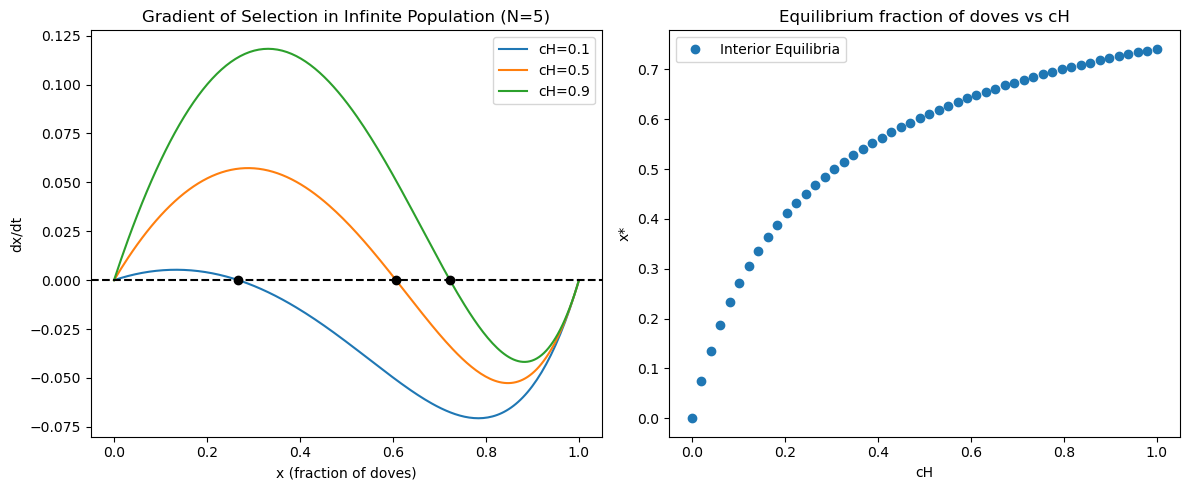

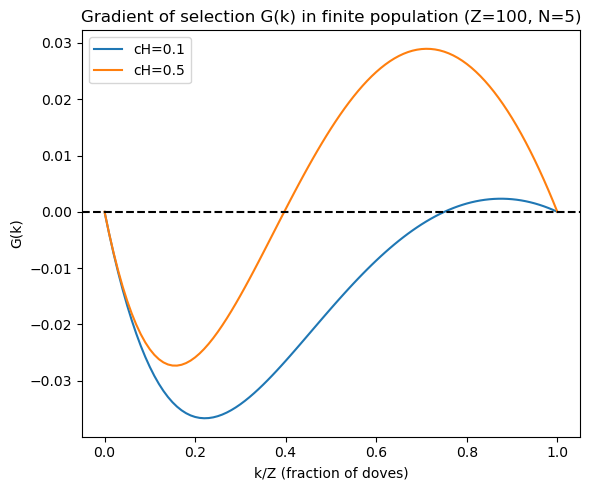